#### Imports

In [1]:
import utilities.logging as Logger
import integration.files as Files
import evaluation.general as GenEval
import evaluation.iv as IVEval
import utilities.macros as Macros
import plotting.plot as Plot
import utilities.constants as Constants
import os

#### Init

In [2]:
bib = Files.DataCollection()

Logger.setup(bib)
Logger.set_level(Logger.INFO)
Files.setup(bib, "Test", rf"/home/{os.getlogin()}/Downloads")
GenEval.setup(bib)
IVEval.setup(bib)

(...) Logger.setup()
(...) Logger.set_level(lvl=Level.INFO)
(...) Files.setup(name=Test, root_dir=/home/dacap/Downloads)
(Test) GenEval.setup()
(Test) IVEval.setup()


#### Config

In [3]:
bib.data.file_name = "2023-11-04_G0_antenna.hdf5"
bib.params.volt_amp = (10000.0, 1000.0)
bib.params.evalTemperature = False
bib.params.linearizeYAxis = True
bib.params.normalizeXAxis = True
bib.params.smoothData = (False, 1)
bib.iv_params.bins = 1200

#### Selection

In [4]:
GenEval.loadMeasurements(bib)
GenEval.showLoadedMeasurements(bib)
GenEval.select_measurement(bib, 1)

IVEval.select_edge(bib, 1, "up")

(Test) GenEval.loadMeasurements()
(Test)   Measurement header format unknown: critical field - list index out of range
(Test)   Measurement header format unknown: frequency_at_-20dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_-25dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_19.3GHz - list index out of range
(Test)   Measurement header format unknown: frequency_at_7.8GHz - list index out of range
(Test) GenEval.showLoadedMeasurements()
(Test)   [1] var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) GenEval.select_measurement(index=1)
(Test)   Selected: var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test)       with: 32 entries
(Test) IVEval.select_edge(num=1,dir=up)


In [5]:
Macros.load(bib, 1)
Macros.eval(bib, "adwin")

(Test) GenEval.select_CurveSet(var_range_index=1)
(Test)   Selected DataSet: nu=-30.0dBm
(Test) IVEval.loadCurveSet()
(Test) IVEval.filter_curve_sets(bin_count=1200)
(Test) IVEval.eval_loaded_curve_set()
(Test) IVEval.get_noise(adwin, ('time', 'current'), It)


In [6]:
Macros.bulk_eval(bib)

(Test)   Evaluating Set: 32/32 (97%) (id: nu=-1.0dBm)(Test) 
Finished evaluating all sets
(Test)   Linearizing Y-axis values from dBm to V


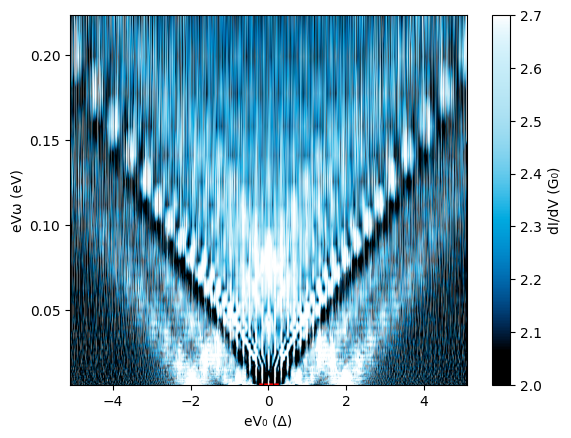

In [7]:
from plotting.plot import StyleKeys as SK

VVI_style = {
    SK.X_LABEL: "eV₀ (Δ)",
    SK.Y_LABEL: "eVω (eV)",
    SK.Z_LABEL: "dI/dV (G₀)",
    SK.SCALE: (1, 1, 1),
    # SK.X_LIM: (-0.001, 0.001),
    # SK.Y_LIM: (0, 0.25),
    SK.CMAP: "seeblau",
    SK.CBAR: True,
    SK.TICKS: (6, 6, 6),
    SK.ASPECT: "auto",
    # SK.INTERPOL: "bilinear",
    SK.FLIP_VERTICAL: True,
}

Plot.map(bib, ["dVXC"], [VVI_style])

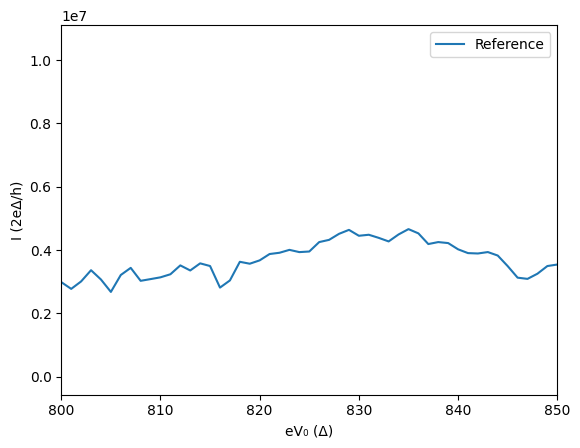

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from utilities.math import moving_average

evolution = 1

plt.figure()

# Macros.load(bib, 1)
# Macros.eval(bib, "adwin")

x1 = bib.result.maps["dVXC"].x_axis.values
y1 = bib.result.maps["dVXC"].values[evolution, :] * 1e6
plt.plot(y1, label="Reference")

plt.xlim(800, 850)

# Macros.load(bib, evolution)
# Macros.eval(bib, "adwin")

# x2 = bib.evaluation.persistent_sets["norm"].curves["voltage-bin"]
# y2 = bib.evaluation.cached_sets["adwin"].curves["current-voltage"] * 1e6
# plt.plot(x2, y2, label="Irradiated")

plt.xlabel("eV₀ (Δ)")
plt.ylabel("I (2eΔ/h)")
# plt.xlim(-6, 6)
# plt.ylim(-15.5, 15.5)
plt.legend()

# plt.figure()

# dx1 = np.gradient(x1)
# dy1 = np.gradient(y1)
# plt.plot(x1, dy1 / dx1, label="Reference")

# dx2 = np.gradient(x2)
# dy2 = np.gradient(y2)
# plt.plot(x2, dy2 / dx2, label="Irradiated")

# plt.xlabel("eV₀ (Δ)")
# plt.ylabel("dI/dV (G₀)")
# # plt.xlim(-6, 6)
# plt.legend(loc="upper left")

# plt.figure()

# dy1 = moving_average(dy1, 10)
# # plt.plot(dy1)
# dy1 = moving_average(dy1, 10)
# # plt.plot(dy1)
# dy1 = moving_average(dy1, 10)
# dy1 = moving_average(dy1, 10)
# plt.plot(dy1)


# y_labels = [
#     GenEval.MeasurementHeader.parse_number(l)[0]
#     for l in bib.params.available_measurement_entries_labels
# ]
# print(sorted(y_labels)[evolution])